In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
import seaborn as sns
import matplotlib.colors as mcolors

In [ ]:
#reading in data
trainData = pd.read_csv("isoletData/isolet1234.data", header=None)
trainData.columns = range(trainData.shape[1])

testData = pd.read_csv("isoletData/isolet5.data", header=None)
testData.columns = range(testData.shape[1])

#separating attributes and labels
trainY = trainData.iloc[:, -1:]
trainX = trainData.drop(trainData.columns[-1],axis=1)
trainSize, _ = trainX.shape

testY = testData.iloc[:, -1:]
testX = testData.drop(testData.columns[-1],axis=1)
testSize, _ = testX.shape

In [13]:
#making one large dataframe for preprocessing
merged = pd.concat([trainX, testX], ignore_index=True, axis=0)
mergedLabels = pd.concat([trainY, testY],ignore_index=True, axis=0)

In [14]:
#performing min-max scaling
scaler = MinMaxScaler()
mergedScaled = scaler.fit_transform(merged.to_numpy())

In [17]:
#performing PCA
pca = PCA().fit(mergedScaled)
totalVariance = np.cumsum(pca.explained_variance_ratio_)
numPCs = np.argmax(totalVariance >= 0.95) + 1
print("Number of Principal Components to Capture 95% variance: ", numPCs)

#fit the data
cleanData = pca.transform(mergedScaled)

#drop the extra components
cleanData = np.delete(cleanData, np.s_[numPCs:], axis=1)

#splitting the cleaned data back into train and test
cleanTrainX = cleanData[:trainSize]
cleanTestX = cleanData[trainSize:]

Number of Principal Components to Capture 95% variance:  179


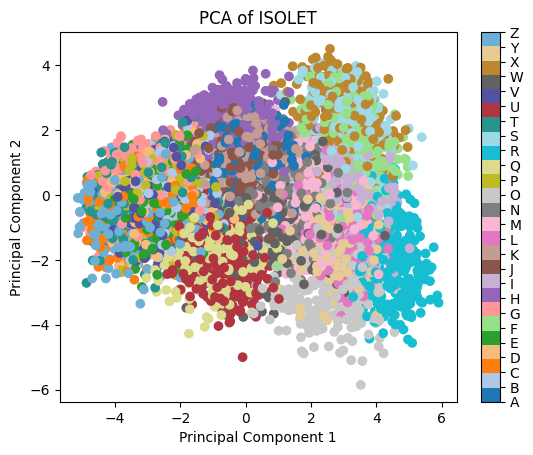

In [6]:
#Graphing the first two principal components

#letter labels
classesString = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

#custom 26 color colorpalatte
colorsCustom = ["#1f78b4", "#afc7e9",'#fe7e10', "#f6bc7c", "#2ba02e", "#97df89", "#ff9799", "#9366b9", "#c6b0d6", "#8c564a", "#c49c94",\
          "#e377c2", "#f7b7d2", "#7f7f7f", "#c8c8c8", "#bdbc23", "#dadb8d", "#17bed1", "#9edae5",\
          "#28948e", "#b13541", "#5253a3", "#626262", '#bd8730', "#e6cb94", "#6cb0d7"]

cmap = mcolors.ListedColormap(colorsCustom)


plt.scatter(cleanData[:, 0], cleanData[:, 1], c=mergedLabels, cmap=cmap)
cbar = plt.colorbar()
ticks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
cbar.set_ticks(ticks)
cbar.set_ticklabels(classesString)
plt.title('PCA of ISOLET')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [7]:
#building the KNN model

#choosing parameters for grid search
params = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19,21], 'algorithm':['ball_tree', 'kd_tree'], 'weights': ['uniform', 'distance']}

#kNN classifier
pcaKNN = KNeighborsClassifier()

# performing grid search with 5 fold cross validation
pcaKNN = GridSearchCV(pcaKNN, params, verbose=0, cv=5)

#fit the model
pcaKNN.fit(cleanTrainX, trainY[617].to_list())

#predict the labels of the testing data
preds = pcaKNN.predict(cleanTestX)

#save the model's report
report = classification_report(testY, preds, digits=6)
reportDict = classification_report(testY, preds, digits=6, output_dict=True)

In [8]:
#print the model's best parameters
print("Best Model Parameters: ", pcaKNN.best_params_)

#print the model's report
print("KNN Model Report")
print(report)

Best Model Parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}
KNN Model Report
              precision    recall  f1-score   support

         1.0   0.950000  0.950000  0.950000        60
         2.0   0.732394  0.866667  0.793893        60
         3.0   0.920635  0.966667  0.943089        60
         4.0   0.843750  0.900000  0.870968        60
         5.0   0.881356  0.866667  0.873950        60
         6.0   0.855072  0.983333  0.914729        60
         7.0   0.920635  0.966667  0.943089        60
         8.0   1.000000  1.000000  1.000000        60
         9.0   1.000000  0.983333  0.991597        60
        10.0   0.923077  1.000000  0.960000        60
        11.0   0.933333  0.933333  0.933333        60
        12.0   0.952381  1.000000  0.975610        60
        13.0   0.809524  0.864407  0.836066        59
        14.0   0.938776  0.766667  0.844037        60
        15.0   1.000000  0.983333  0.991597        60
        16.0   0.875000  0

In [ ]:
#collect F1 scores
f1Scores = [value['f1-score'] for key, value in reportDict.items() if isinstance(value, dict) and 'f1-score' in value and key not in ['accuracy', 'macro avg', 'weighted avg']]

classes = [x for x in range(1,27)]

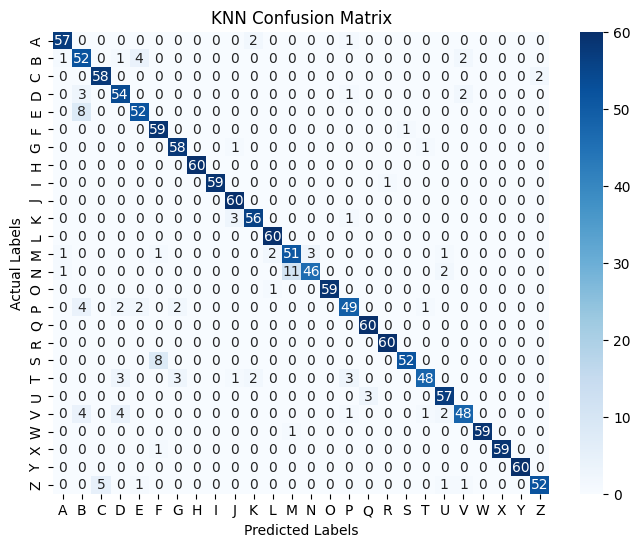

In [30]:
#confusion matrix with letter labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(testY, preds), annot=True, cmap='Blues', fmt='d', cbar=True,  yticklabels=classesString, xticklabels=classesString)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

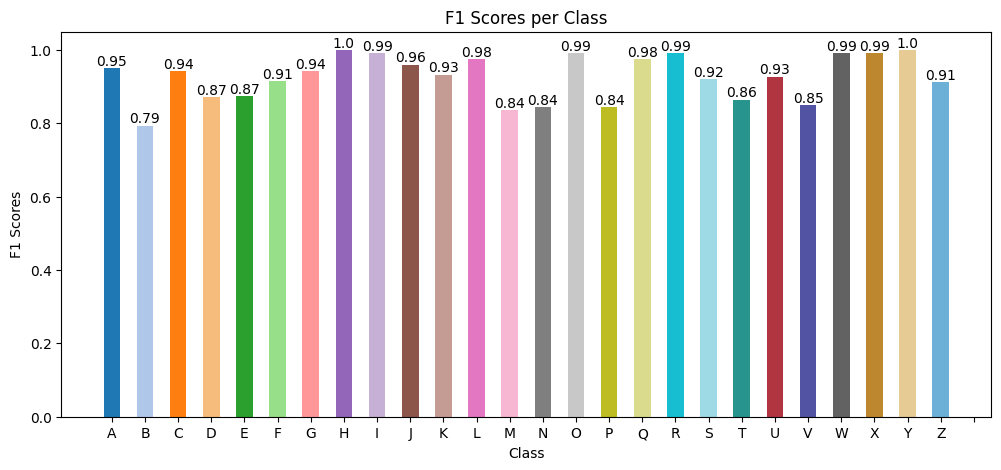

In [31]:
#graphs F1 scores per class with letter labels

fig = plt.figure(figsize = (12, 5))

# creating the bar plot
colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))
bars = plt.bar(classesString, f1Scores, color=colorsCustom, width = 0.5, label=classesString)
plt.bar_label(bars, labels=[round(x,2) for x in f1Scores])

plt.xlabel("Class")
plt.ylabel("F1 Scores")
plt.title("F1 Scores per Class")
plt.xticks(np.arange(0, 27, 1))
plt.show()

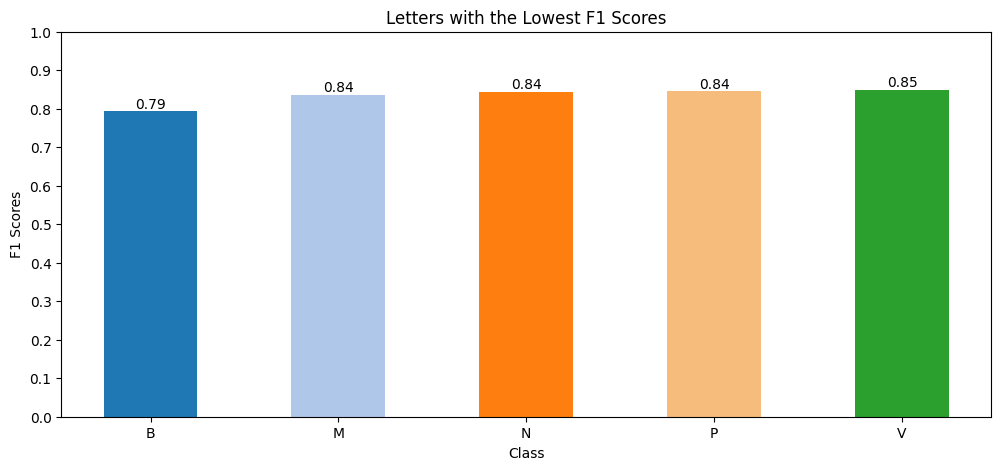

In [48]:
#graphs F1 scores of lowest classes with letter labels

#find lowest letters
minNumber = 5
pairs = sorted(zip(classesString,f1Scores), key=lambda x:x[1])
lowestLetters = pairs[0:minNumber]


# creating the bar plot
fig = plt.figure(figsize = (12, 5))

colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))
bars = plt.bar([pair[0] for pair in lowestLetters], [pair[1] for pair in lowestLetters], color=colorsCustom, width = 0.5, label=[pair[0] for pair in lowestLetters])
plt.bar_label(bars, labels=[round(pair[1],2) for pair in lowestLetters])

plt.xlabel("Class")
plt.ylabel("F1 Scores")
plt.title("Letters with the Lowest F1 Scores")
plt.xticks(np.arange(0, minNumber, 1))
plt.yticks(np.arange(0, 1.1, .1))
plt.show()

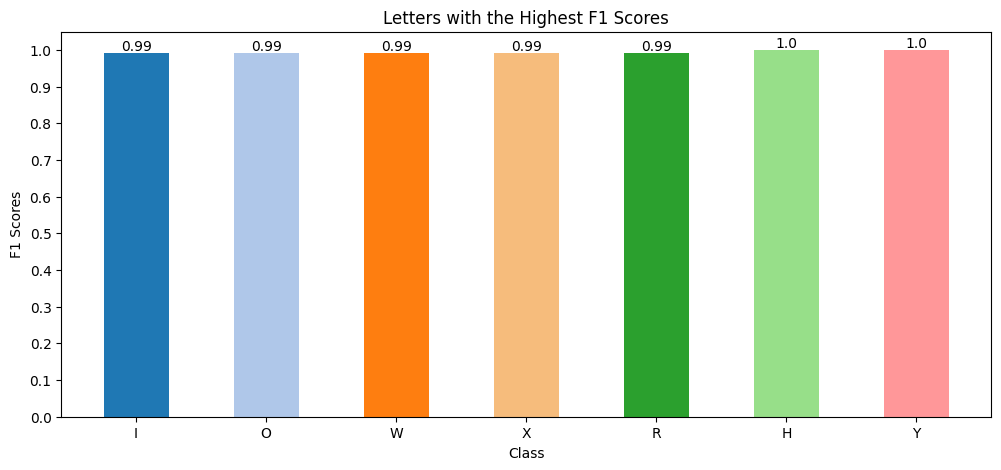

In [49]:
#graphs F1 scores of highest classes with letter labels

#find highest letters
maxNumber = 7
pairs = sorted(zip(classesString,f1Scores), key=lambda x:x[1])
highestLetters = pairs[-maxNumber:]


# creating the bar plot
fig = plt.figure(figsize = (12, 5))

colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))
bars = plt.bar([pair[0] for pair in highestLetters], [pair[1] for pair in highestLetters], color=colorsCustom, width = 0.5, label=[pair[0] for pair in highestLetters])
plt.bar_label(bars, labels=[round(pair[1],2) for pair in highestLetters])

plt.xlabel("Class")
plt.ylabel("F1 Scores")
plt.title("Letters with the Highest F1 Scores")
plt.xticks(np.arange(0, maxNumber, 1))
plt.yticks(np.arange(0, 1.1, .1))
plt.show()